Circulant Blur Image Deconvolution with TV Regularization
=========================================================

This example demonstrates the solution of an image deconvolution problem
with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is a circular convolution operator, $\mathbf{y}$ is the blurred
image, $C$ is a 2D finite difference operator, and $\mathbf{x}$ is the
deconvolved image.

In [1]:
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize.admm import ADMM, CircularConvolveSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
N = 256  # image size
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)

Set up the forward operator and create a test signal consisting of a
blurred signal with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.CircularConvolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

Set up an ADMM solver object.

In [4]:
λ = 2e-2  # ℓ2,1 norm regularization parameter
ρ = 5e-1  # ADMM penalty parameter
maxiter = 50  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
g = λ * functional.L21Norm()  # regularization functionals gi
C = linop.FiniteDifference(x_gt.shape, circular=True)
solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=CircularConvolveSolver(),
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.99e+00  3.282e+02  6.286e+00  4.074e+00
  10  3.30e+00  3.286e+02  2.953e-01  1.032e+00
  20  3.39e+00  3.253e+02  1.300e-01  6.202e-01


  30  3.48e+00  3.239e+02  7.343e-02  4.347e-01
  40  3.58e+00  3.233e+02  4.879e-02  3.257e-01


  49  3.66e+00  3.229e+02  3.805e-02  2.584e-01


Show the recovered image.

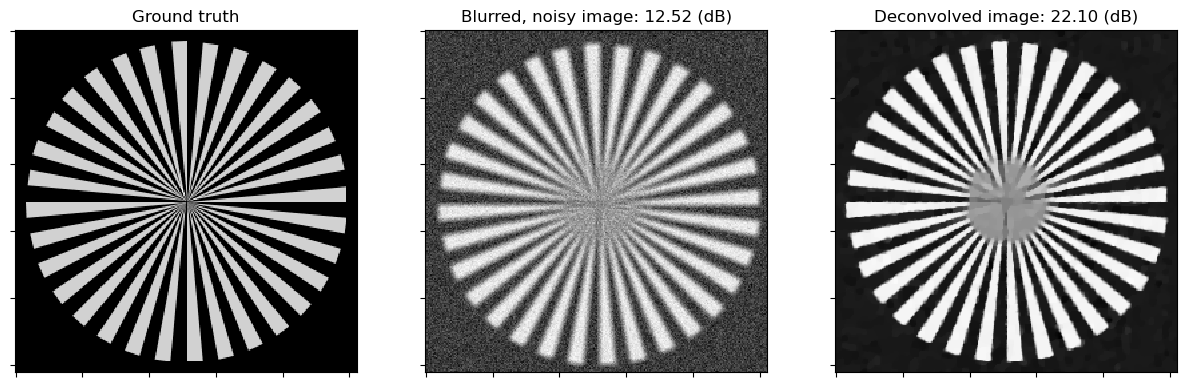

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, y), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

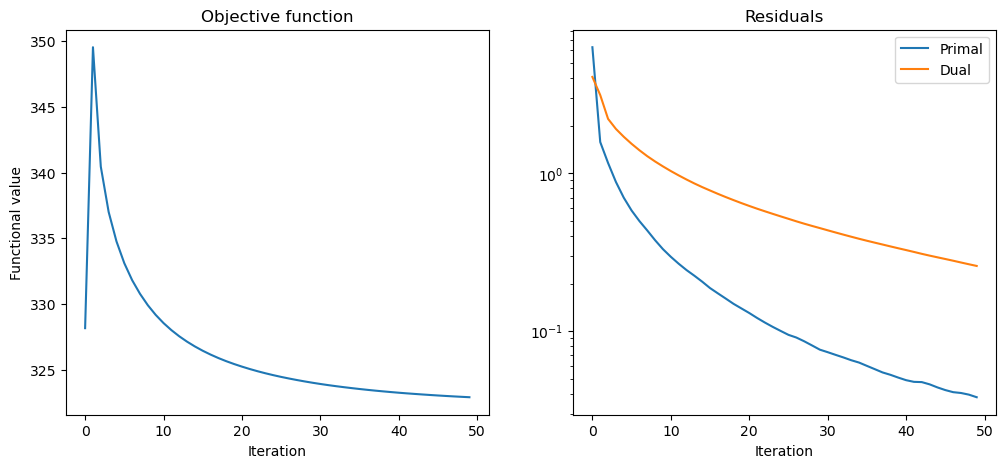

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()